# Install or upgrade libraries

It might be that you are running with the latest libraries and that they all work together fine. 

Running the following cell takes a minute or so but ensures that you have a consistent set of python tools. 

In [ ]:
# If there are issues with fsspect-xrootd not being found, run this outside of Jupyter-notebook and restart
# !pip install --upgrade fsspec-xrootd

In [ ]:
'''
!pip install --upgrade pip

!pip install futures 

!pip install --user --upgrade coffea

!pip install --upgrade awkward
!pip install --upgrade uproot

!pip install --upgrade fsspec-xrootd

!pip install vector

!pip install --upgrade pandas


!pip install --upgrade matplotlib
'''

We've also prepared some helper code that makes it easier to work with the data in this lesson.

You can see the code [here](https://github.com/cms-opendata-workshop/workshop2024-lesson-event-selection/blob/main/instructors/dpoa_workshop_utilities.py) but we will explain the functions and data objects in this notebook. 

Let's download it first. 

In [ ]:
#!wget https://raw.githubusercontent.com/cms-opendata-workshop/workshop2024-lesson-event-selection/main/instructors/dpoa_workshop_utilities.py

## Imports

Import all the libraries we will need and check their versions, in case you run into issues. 

In [1]:
%load_ext autoreload
%autoreload 2
import sys
print(f"{sys.version = }\n")

# The classics
import numpy as np
import matplotlib.pylab as plt
import matplotlib # To get the version

import pandas as pd

# The newcomers
import awkward as ak
import uproot

import vector
vector.register_awkward()

import requests
import os
    
import time

import json

import dpoa_workshop_utilities
from dpoa_workshop_utilities import nanoaod_filenames
from dpoa_workshop_utilities import get_files_for_dataset    
from dpoa_workshop_utilities import pretty_print
from dpoa_workshop_utilities import build_lumi_mask

sys.version = '3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]'



In [2]:
print("Versions --------\n")
print(f"{sys.version = }\n")
print(f"{ak.__version__ = }\n")
print(f"{uproot.__version__ = }\n")
print(f"{np.__version__ = }\n")
print(f"{matplotlib.__version__ = }\n")
print(f"{vector.__version__ = }\n")
print(f"{pd.__version__ = }\n")

Versions --------

sys.version = '3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]'

ak.__version__ = '2.8.4'

uproot.__version__ = '5.6.2'

np.__version__ = '2.2.6'

matplotlib.__version__ = '3.10.3'

vector.__version__ = '1.6.2'

pd.__version__ = '2.3.0'



# Opening a file

Let's open and explore a sample file. 

We'll be getting the data from [here](https://opendata.cern.ch/record/67993).

This is some Monte Carlo that contains simulations of a top-antitop pair being created in a proton-proton collision at CMS. 

One top decays leptonically and the other decays hadronically. 

**Do you know what leptonically and hadronically mean? If not, do a bit of research.**

When you go to open the file, it might take 10-30 seconds at this step if you are working with the larger file.

In [3]:
# # For testing
# # Big file
# #filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'

# # Smaller file, better for prototyping your code as things will run faster
# filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'

# print(f"Opening...{filename}")
# f = uproot.open(filename)

# events = f['Events']

# nevents = events.num_entries

# print(f"{nevents = }")

In [3]:
def load_file(size):
    '''
    size = "big" or "small" or "RunIISuummer20" or JetHT"
    '''
    if size == "big": 
        # Big file
        filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root'
    elif size == "small":
        # Smaller file, better for prototyping your code as things will run faster
        filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root'
    elif size == "RunIISummer20": 
        filename = 'root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/1F546B5D-D09E-3B4B-8AA3-51DE65483612.root'
    elif size == "JetHT":
        filename = 'root://eospublic.cern.ch//eos/opendata/cms/Run2016H/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/0290F73B-A51C-A441-AEC1-8429F9CC8AA8.root'
    print(f"Opening...{filename}")
    f = uproot.open(filename)

    events = f['Events']

    nevents = events.num_entries

    print(f"{nevents = }")
    return events

In [4]:
small_events = load_file("small")
big_events = load_file("big")
RunII_events = load_file("RunIISummer20")
JetHT_events = load_file("JetHT")

Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/7D120E49-E712-B74B-9E1C-67F2D0057995.root
nevents = 168000
Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/08FCB2ED-176B-064B-85AB-37B898773B98.root
nevents = 1233000
Opening...root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-800To1000_MuEnrichedPt5_TuneCP5_13TeV-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/120000/1F546B5D-D09E-3B4B-8AA3-51DE65483612.root
nevents = 599928
Opening...root://eospublic.cern.ch//eos/opendata/cms/Run2016H/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/0290F73B-A51C-A441-AEC1-8429F9CC8AA8.root
nevents = 1763723


In [16]:
#Change the variable to change to other datasets, so that you don't need to load each time you want a new array
events = RunII_events 

The `events` object is a `TTree` implementation in python and behaves like a dictionary. This means 
we can get all the keys if we want. 

In [6]:
# Uncomment the following line to print all the keys

#print(events.keys())

Again, we have provided you with a helper function called `pretty_print` that will print subsets of the keys, based on strings
that you require or ignore. 

It will also format that output based on how many characters you want in a column (you are limited to 80 characters per line). 

Here is some example usage. 

In [8]:
# Pretty print all the keys with the default format
#pretty_print(events.keys())

# Pretty print keys with 30 characters per column, for keys that contain `FatJet`
#pretty_print(events.keys(), fmt='30s', require='FatJet')

# Pretty print keys with 40 characters per column, for keys that contain `Muon` and `Iso` but ignore ones with `HLT`
#pretty_print(events.keys(), fmt='40s', require=['Muon', 'Iso'], ignore='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `HLT` and `TkMu50`
#pretty_print(events.keys(), fmt='40s', require=['HLT', 'TkMu50'])

# Pretty print keys with 40 characters per column, for keys that contain `HLT`
#pretty_print(events.keys(), fmt='40s', require='HLT')

# Pretty print keys with 40 characters per column, for keys that contain `Jet_` but ignore ones with `Fat`
pretty_print(events.keys(), fmt='40s', require='Jet_', ignore='Fat')

# Pretty print keys with 40 characters per column, for keys that contain `PuppiMET` but ignore ones with `Raw`
#pretty_print(events.keys(), fmt='40s', require='PuppiMET', ignore='Raw')

CorrT1METJet_area                        CorrT1METJet_eta                         
CorrT1METJet_muonSubtrFactor             CorrT1METJet_phi                         
CorrT1METJet_rawPt                       GenJet_eta                               
GenJet_mass                              GenJet_phi                               
GenJet_pt                                Jet_area                                 
Jet_btagCSVV2                            Jet_btagDeepB                            
Jet_btagDeepCvB                          Jet_btagDeepCvL                          
Jet_btagDeepFlavB                        Jet_btagDeepFlavCvB                      
Jet_btagDeepFlavCvL                      Jet_btagDeepFlavQG                       
Jet_chEmEF                               Jet_chFPV0EF                             
Jet_chHEF                                Jet_eta                                  
Jet_hfsigmaEtaEta                        Jet_hfsigmaPhiPhi                        
Jet_

## Extract some data

We're going to pull out subsets of the data in order to do our analysis. 

As a reminder, you can find a list of the variable names in each dataset on the CERN Open Data Portal page for that dataset, for example, [here](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAODSIM/75156/ZprimeToTT_M2000_W20_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8_doc.html).

We're going to work with the following sets of variables
* `FatJet` for jets that are merges
* `Jet` for non-merged jets
* `Muon` for muons
* `PuppiMET` which is missing energy in the transverse plane (MET) for pileup per particle identification (Puppi)

Running this cell might take a little bit if you are running over the bigger file. However, once you pull out the values, later calculations are much faster. 

In [4]:
start_time = time.time()

# Jets ---------------------------------------------------
# B-tagging variable
jet_btagB = events['Jet_btagDeepB'].array()
jet_btagFlavB = events ['Jet_btagDeepFlavB'].array()

# Quark-Gluon Likelihood
jet_qgl = events["Jet_qgl"].array()

# Measure of quality of measurement of jet
jet_jetid = events['Jet_jetId'].array()

# 4-momentum in pt, eta, phi, mass 
jet_pt = events['Jet_pt'].array()
jet_eta = events['Jet_eta'].array()
jet_phi = events['Jet_phi'].array()
jet_mass = events['Jet_mass'].array()


# Muons ---------------------------------------------------
# Muon isolation
muon_iso = events['Muon_miniIsoId'].array()

# Measure of quality of how well the muon is reconstructed
muon_tightId = events['Muon_tightId'].array()

# 4-momentum in pt, eta, phi, mass 
muon_pt = events['Muon_pt'].array()
muon_eta = events['Muon_eta'].array()
muon_phi = events['Muon_phi'].array()
muon_mass = events['Muon_mass'].array()


# MET ------------------------------------------------------
# 3-momentum in pt, eta, phi, mass 
met_pt = events['PuppiMET_pt'].array()
met_eta = 0*events['PuppiMET_pt'].array()  # Fix this to be 0
met_phi = events['PuppiMET_phi'].array() 

#FatJets ----------------------------------------------------
# 4-momentum in pt, eta, phi, mass 
fatjet_pt = events['FatJet_pt'].array()
fatjet_eta = events['FatJet_eta'].array()
fatjet_phi = events['FatJet_phi'].array()
fatjet_mass = events['FatJet_mass'].array()

print(f'Time to access data is {time.time() - start_time:.2f} seconds')

NameError: name 'events' is not defined

In [18]:
## Putting Data into Structured Variables (Awkward)

fatjets = ak.zip(
    {"pt": fatjet_pt, 
     "eta": fatjet_eta, 
     "phi": fatjet_phi, 
     "mass": fatjet_mass},
    with_name="Momentum4D",
)

muons = ak.zip(
    {"pt": muon_pt, 
     "eta": muon_eta, 
     "phi": muon_phi, 
     "mass": muon_mass},
    with_name="Momentum4D",
)

jets = ak.zip(
    {"pt": jet_pt, 
     "eta": jet_eta, 
     "phi": jet_phi, 
     "mass": jet_mass,
     "DeepB": jet_btagB,
     "QGL": jet_qgl },
    with_name="Momentum4D",
)

met = ak.zip(
    {"pt": met_pt, 
     "eta": met_eta, 
     "phi": met_phi, 
     "mass": 0}, # We assume this is a neutrino with 0 mass
    with_name="Momentum4D",
)


# What comes next?  

## Basic Plots

- Simple Muon Cuts (pt > cut)
- Simpe Jet Cuts (pt > cut)
- The B-tag cut (DeepB > tight, medium, loose)

In [ ]:
#Simple Muon and Jet cuts 
muon_cut = muon_pt > 20 
jet_cut = jet_pt > 20 

cuts = [0, 10, 15, 20]
for cut in cuts: 
    muon_cut = muon_pt > cut 
    jet_cut = jet_pt > cut
    
    muon_pt_cut = muon_pt[muon_cut]
    jet_pt_cut = jet_pt[jet_cut]

    nmuon = ak.num(muon_pt_cut)
    njet = ak.num(jet_pt_cut)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.hist(nmuon, bins=100);
    plt.xlabel("No of Muons")
    plt.ylabel("No of Events")
    plt.subplot(1,2,2)
    plt.hist(njet,bins=100);
    plt.xlabel("No of Jets")
    plt.ylabel("No of Events")

In [ ]:
#btag_cuts
'''Values: 
Loose (10% misidentification rate): Jet_btagDeepB > 0.1918 , Jet_btagDeepFlavB > 0.0480
Medium (1% misidentification rate): Jet_btagDeepB > 0.5847, Jet_btagDeepFlavB > 0.2489
Tight (0.1% misidentification rate): Jet_btagDeepB > 0.8767, Jet_btagDeepFlavB > 0.6377
'''
def give_btag_cuts(choice, accuracy):
    '''
    choice = "DeepB" or "DeepFlav" 
    accuracy = "loose" "medium" or "tight" 

    Loose:  Jet_btagDeepB > 0.1918 , Jet_btagDeepFlavB > 0.0480
    Medium: Jet_btagDeepB > 0.5847, Jet_btagDeepFlavB > 0.2489
    Tight: Jet_btagDeepB > 0.8767, Jet_btagDeepFlavB > 0.6377
    '''
    if (choice == "DeepB") & (accuracy == "tight") : return jet_btagB > 0.8767
    if (choice == "DeepB") & (accuracy == "medium"): return jet_btagB > 0.5847
    if (choice == "DeepB") & (accuracy == "loose"): return jet_btagB > 0.1918

    if choice == "DeepFlav":
        if accuracy == "tight": return jet_btagFlavB > 0.6377
        if accuracy == "medium": return jet_btagFlavB > 0.2489
        if accuracy == "loose": return jet_btagFlavB > 0.0480

jet_btag_tight = jet_pt[give_btag_cuts("DeepB","tight")]
jet_btag_medium = jet_pt[give_btag_cuts("DeepB","medium")]
jet_btag_loose = jet_pt[give_btag_cuts("DeepB","loose")]

njet_btag_tight = ak.num(jet_btag_tight)
njet_btag_medium = ak.num(jet_btag_medium)
njet_btag_loose = ak.num(jet_btag_loose)

#Comparision of btagging loose, medium and tight
edgecolors = ['red', 'orange' , 'yellow']
all_njets = [njet_btag_tight, njet_btag_medium, njet_btag_loose]
names = ["tight", "medium", "loose"]
for all, name in zip(all_njets,names): 
    plt.hist(all, bins = 100, alpha = 0.5, label = f"Accuracy = {name}")
    plt.legend()
plt.xlabel("No of Jets")
plt.ylabel("No of Events")
plt.show()

#Comparison of the two different btagging 
jet_btagF_tight = jet_pt[give_btag_cuts("DeepFlav","tight")]
jet_btagF_medium = jet_pt[give_btag_cuts("DeepFlav","medium")]
jet_btagF_loose = jet_pt[give_btag_cuts("DeepFlav","loose")]

njet_btagF_tight = ak.num(jet_btagF_tight)
njet_btagF_medium = ak.num(jet_btagF_medium)
njet_btagF_loose = ak.num(jet_btagF_loose)

plt.subplot(3, 1, 1)
plt.hist(njet_btagF_tight, bins = 100,label= "DeepFlav");
plt.hist(njet_btag_tight, bins=100, label = "DeepB");
plt.legend()

plt.subplot(3,1,2)
plt.hist(njet_btagF_medium, bins = 100, label = "DeepFlav");
plt.hist(njet_btag_medium, bins=100, label = "DeepB");
plt.legend()

plt.subplot(3,1,3)
plt.hist(njet_btagF_loose, bins = 100, label = "DeepFlav");
plt.hist(njet_btag_loose, bins=100, label = "DeepB");
plt.legend()

plt.tight_layout()

In [ ]:
#Mixing b_tag and jet_cuts
jet_cut = jet_pt > cut
jet_pt_cut = jet_pt[jet_cut]
jet_pt_btag_cut1 = jet_pt[give_btag_cuts("DeepB","loose")[jet_cut]]
jet_pt_btag_cut2 = jet_pt[give_btag_cuts("DeepB","medium")[jet_cut]]
jet_pt_btag_cut3 = jet_pt[give_btag_cuts("DeepB","tight")[jet_cut]]
njet_pt_btag_cut1 = ak.num(jet_pt_btag_cut1);
njet_pt_btag_cut2 = ak.num(jet_pt_btag_cut2);
njet_pt_btag_cut3 = ak.num(jet_pt_btag_cut3);
plt.hist(njet_pt_btag_cut1, bins = 100, label = f"Cut Count: {ak.sum(njet_pt_btag_cut1)} Accuracy: Loose");
plt.hist(njet_pt_btag_cut2, bins = 100, label = f"Cut Count: {ak.sum(njet_pt_btag_cut2)} Accuracy: Medium");
plt.hist(njet_pt_btag_cut3, bins = 100, label = f"Cut Count: {ak.sum(njet_pt_btag_cut3)} Accuracy: Tight");
plt.legend()

## Invariant Masses of the Top Quark and W Boson

In [ ]:
jet_DeepB=events["Jet_btagDeepB"].array()


In [ ]:
#Finding the invariant mass 
fatjets = ak.zip(
    {"pt": fatjet_pt, 
     "eta": fatjet_eta, 
     "phi": fatjet_phi, 
     "mass": fatjet_mass},
    with_name="Momentum4D",
)

muons = ak.zip(
    {"pt": muon_pt, 
     "eta": muon_eta, 
     "phi": muon_phi, 
     "mass": muon_mass},
    with_name="Momentum4D",
)

jets = ak.zip(
    {"pt": jet_pt, 
     "eta": jet_eta, 
     "phi": jet_phi, 
     "mass": jet_mass,
     "DeepB": jet_DeepB},
    with_name="Momentum4D",
)

met = ak.zip(
    {"pt": met_pt, 
     "eta": met_eta, 
     "phi": met_phi, 
     "mass": 0}, # We assume this is a neutrino with 0 mass
    with_name="Momentum4D",
)


In [ ]:
# Cuts

#Muons and Jet Cuts 
muon_cut = (muons.pt > 20) & (np.abs(muons.eta) < 2.1)
jet_cut = (jets.pt>20) & (np.abs(jets.eta) < 2.4)

muons_cut = muons[muon_cut]
jets_cut = jets[jet_cut]

n_muon = ak.num(muons_cut)
n_jets = ak.num(jets_cut)
n_bjets = ak.sum(jets.DeepB > 0.8767, axis = 1) 

mega_cut = (n_muon == 1) & (n_jets == 4) & (n_bjets == 2)

jets_mcut = jets_cut[mega_cut]

trijet = ak.combinations(jets_mcut, 3, fields=["j1", "j2", "j3"])
trijet["p4"] = trijet.j1 +  trijet.j2 +  trijet.j3                       
threshold_1 = 0.8767
threshold_2 = 0.2
# btag_count1= (trijet.j1.DeepB > threshold_1) + (trijet.j2.DeepB > threshold_1) + (trijet.j3.DeepB > threshold_1)
# btag_count2= (trijet.j1.DeepB < threshold) + (trijet.j2.DeepB < threshold) + (trijet.j3.DeepB < threshold_2)
# mask1 = btag_count1 == 1
# mask2 = btag_count2 == 2
btag_mask = ((trijet.j1.DeepB > threshold_1) & (trijet.j2.DeepB < threshold_2) & (trijet.j3.DeepB < threshold_2)) | \
            ((trijet.j1.DeepB < threshold_2) & (trijet.j2.DeepB > threshold_1) & (trijet.j3.DeepB < threshold_2)) | \
            ((trijet.j1.DeepB < threshold_2) & (trijet.j2.DeepB < threshold_2) & (trijet.j3.DeepB > threshold_1)) 
trijet_mass = trijet["p4"][btag_mask][ak.argmax(trijet.p4.pt[btag_mask], axis =1, keepdims = True)].mass

tri_imass = ak.flatten(trijet_mass)
plt.hist(tri_imass, bins = 100,range=(0,400))
plt.axvline(175, color = "red",ls="--",label="Mass of Top Quark")
plt.legend()

In [ ]:
trijet.j2[0][0], trijet.j3[0][0], trijet.p4[0][0]

In [ ]:
#DiJet Particle Mass 
mini_cut = (n_muon == 1) & (n_jets == 4)

mincut_jet = jets_cut[mini_cut]

dijet = ak.combinations(mincut_jet, 2, fields=["j1",  "j2"])
dijet["p3"] = dijet.j1 +  dijet.j2     
mask = (dijet.j1.DeepB < threshold_1) & (dijet.j2.DeepB < threshold_1) 
dijet = dijet[mask]
dijet_mass = dijet["p3"][ak.argmax(dijet.p3.pt, axis =1, keepdims = True)].mass  
di_imass = ak.flatten(dijet_mass)
plt.hist(di_imass, bins = 100, range=(0,250))
plt.axvline(80.3, color = "red",ls="--",label="Mass of W boson")
plt.legend()

In [ ]:
trijet.j1[0][0]

## Getting 4jet combination mass from 8jets

In [19]:
import matplotlib.colors as colors

In [20]:
# 8-jets and 4-combinations: Samyak
start_time = time.time()
jet_cut = (jets.pt>20) & (np.abs(jets.eta) < 2.4) #& (jets.QGL > 0.5)
jets_cut = jets[jet_cut]

n_jets = ak.num(jets_cut)
n_jets_mask = n_jets == 8
jets_ncut = jets_cut[n_jets_mask]

disjoint_combo1=[]
disjoint_combo2=[]
quadrajet = ak.combinations(jets_ncut, 4, fields=["j1", "j2", "j3","j4"])
quadrajet["p4"]=quadrajet.j1 + quadrajet.j2 + quadrajet.j3 + quadrajet.j4 
for insanity in quadrajet: 
    disjoint_combo1.append(insanity[0:35])
    disjoint_combo2.append(insanity[35:70][::-1])
print(f'Time to rearrange the combinations is {time.time() - start_time:.2f} seconds')    

Time to rearrange the combinations is 29.20 seconds


In [21]:
combocombo1=[]
combocombo2=[]
start_time = time.time()
for i in range(len(disjoint_combo1)):
    combocombo1.append(disjoint_combo1[i]["p4"].mass.to_list())
    combocombo2.append(disjoint_combo2[i]["p4"].mass.to_list())
print(f'Time to calculate the mass is {time.time() - start_time:.2f} seconds')  

Time to calculate the mass is 85.37 seconds


Time for plotting a scatter plot is 6.89 seconds
Time to plot a 2D histogram is 0.39 seconds


(0.0, 6000.0)

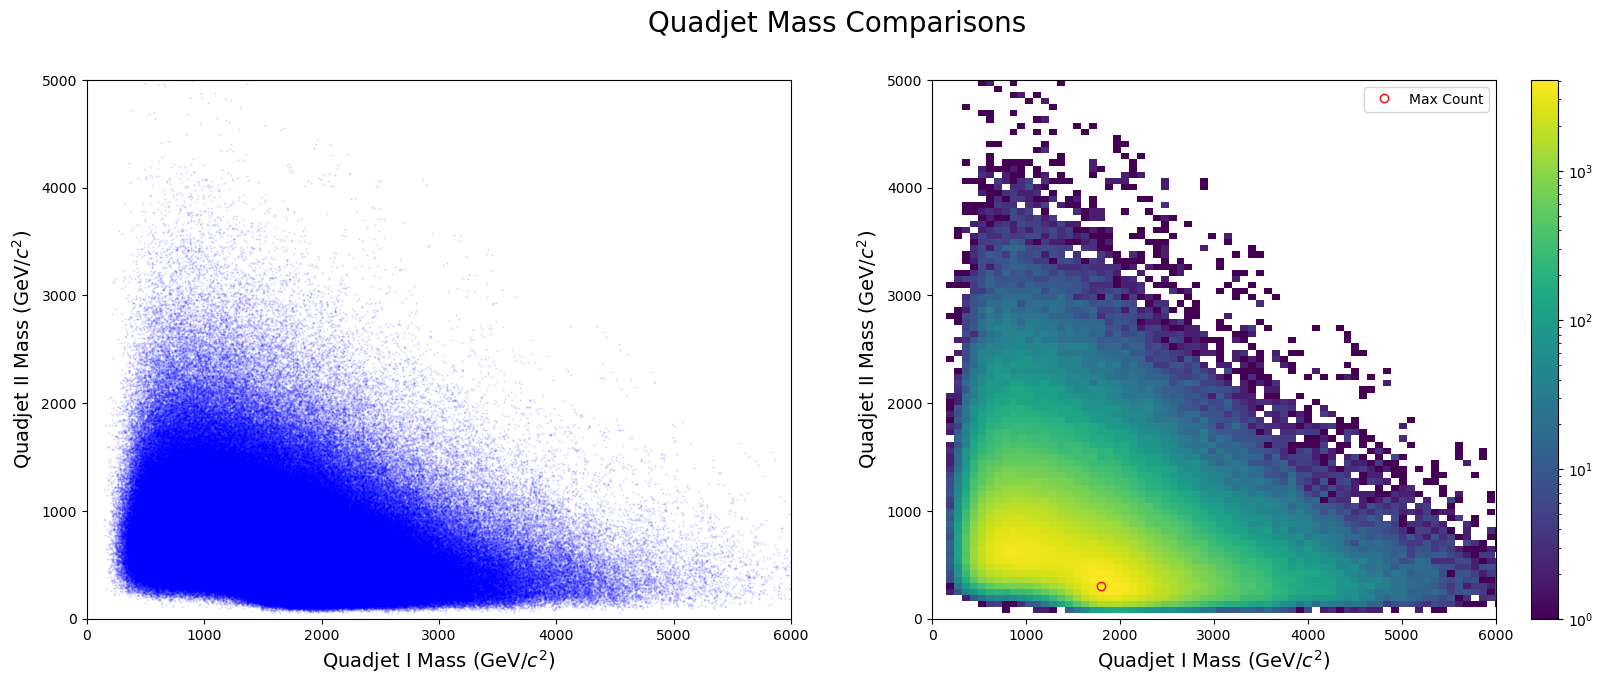

In [43]:
plt.figure(figsize=(20,7))
plt.suptitle("Quadjet Mass Comparisons",fontsize=20)
plt.subplot(1,2,1)
start_time = time.time()
plt.scatter(ak.flatten(combocombo1).to_list(), ak.flatten(combocombo2).to_list(), color="blue",s=0.5,alpha=0.1)
plt.xlabel("Quadjet I Mass (GeV/$c^2$)", fontsize=14)
plt.ylabel("Quadjet II Mass (GeV/$c^2$)",fontsize=14)
plt.ylim(0,5000)
plt.xlim(0,6000)
print(f'Time for plotting a scatter plot is {time.time() - start_time:.2f} seconds')    
plt.subplot(1,2,2)
start_time = time.time()
counts, xedges, yedges, _ = plt.hist2d(ak.flatten(combocombo1).to_list(), ak.flatten(combocombo2).to_list(),bins=100, norm=colors.LogNorm())
i, j = np.unravel_index(np.argmax(counts), counts.shape)
x_peak = (xedges[i] + xedges[i+1])/2 
y_peak = (yedges[j] + yedges[j+1])/2 
plt.plot(x_peak, y_peak,"ro", markerfacecolor="none",label="Max Count")
plt.colorbar()
plt.xlabel("Quadjet I Mass (GeV/$c^2$)", fontsize=14)
plt.ylabel("Quadjet II Mass (GeV/$c^2$)",fontsize=14)
print(f'Time to plot a 2D histogram is {time.time() - start_time:.2f} seconds')  
plt.legend()
plt.ylim(0,5000)
plt.xlim(0,6000)

Time to plot a 2D histogram is 0.42 seconds


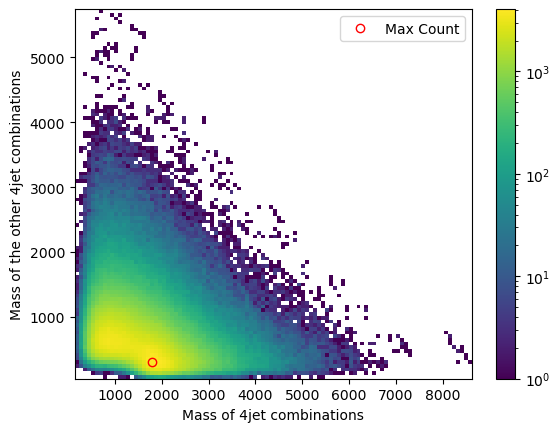

In [24]:
len(ak.flatten(combocombo1))

1066100

## Dijets from Quadjets A.K.A Combinatorics Hell (hopefully not)

In [9]:
# Cuts 
start_time1 = time.time()
jet_cut = (jets.pt>20) & (np.abs(jets.eta) < 2.4) #& (jets.QGL > 0.5)
jets_cut = jets[jet_cut]

n_jets = ak.num(jets_cut)
n_jets_mask = n_jets == 8 
jets_ncut = jets_cut[n_jets_mask]

disjoint_combo1=[]
disjoint_combo2=[]
print(f"Cutting: {time.time() - start_time1}")

# Making disjointed 8C4 combinations
start_time2 = time.time()
quadrajet = ak.combinations(jets_ncut, 4, fields=["j1", "j2", "j3","j4"])
for insanity in quadrajet: 
    disjoint_combo1.append(insanity[0:35])
    disjoint_combo2.append(insanity[35:70][::-1])
print(f"Pairing the 8C4 disjointed combinations: {time.time() - start_time2}")

# Calculating Dijet Masses from the First Quadjet 
start_time3 = time.time()
jet1=[]
jet2=[]
jet3=[]
jet4=[]
for jet_combo1,jet_combo2 in zip(disjoint_combo1,disjoint_combo2): 
    dijet1 = jet_combo1.j1 + jet_combo1.j2
    dijet2 = jet_combo1.j3 + jet_combo1.j4
    dijet3 = jet_combo2.j1 + jet_combo2.j2
    dijet4 = jet_combo2.j3 + jet_combo2.j4
    jet1.append(dijet1.mass) 
    jet2.append(dijet2.mass)
    jet3.append(dijet3.mass) 
    jet4.append(dijet4.mass)
  
print(f"Pairing and Calculating Mass of the Quadjets: {time.time() - start_time3}")

start_time5 = time.time()
jet1_flat = ak.flatten(jet1)
jet2_flat = ak.flatten(jet2)
jet3_flat = ak.flatten(jet3)
jet4_flat = ak.flatten(jet4)

print(f"Flattening the Data: {time.time() - start_time5}")

print(f"The whole code block: {time.time() - start_time1}")

Cutting: 0.060451507568359375
Pairing the 8C4 disjointed combinations: 0.048528194427490234
Pairing and Calculating Mass of the Quadjets: 1.6200742721557617
Flattening the Data: 0.08812665939331055
The whole code block: 1.8175735473632812


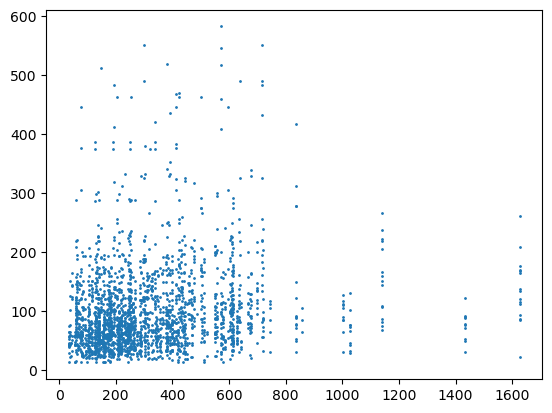

In [28]:
plt.scatter(jet1_flat , jet2_flat,s=1);
#plt.xlim(0,400);
#plt.ylim(0,1000);

In [29]:
import matplotlib.colors as colors

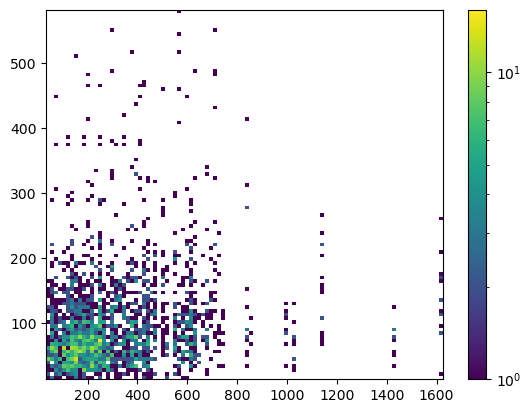

In [30]:
plt.hist2d(jet1_flat.to_list() , jet2_flat.to_list(),bins=100, norm=colors.LogNorm());
plt.colorbar()
#plt.xlim(0,40);
#plt.ylim(0,40);

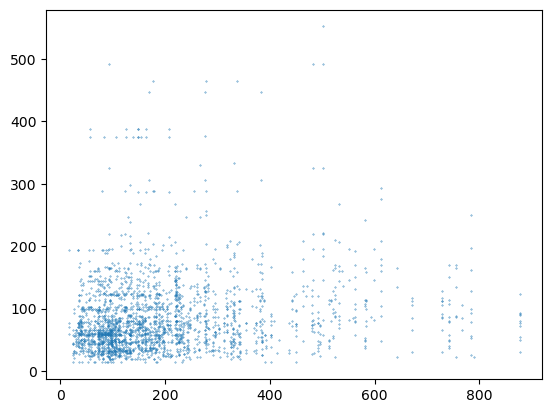

In [31]:
plt.scatter(jet3_flat , jet4_flat,s=0.1);
#plt.xlim(0,500);
#plt.ylim(0,150);

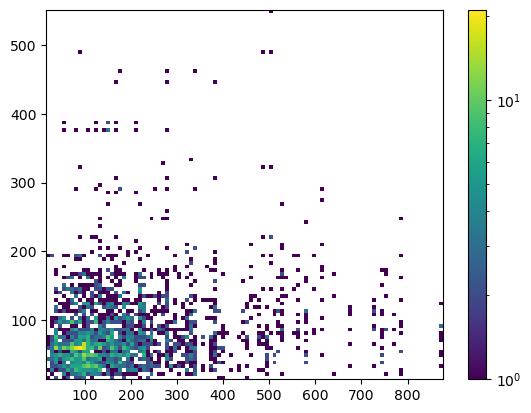

In [32]:
plt.hist2d(jet3_flat.to_list() ,jet4_flat.to_list(),bins=100, norm=colors.LogNorm());
plt.colorbar()
#plt.xlim(0,40);
#plt.ylim(0,40);

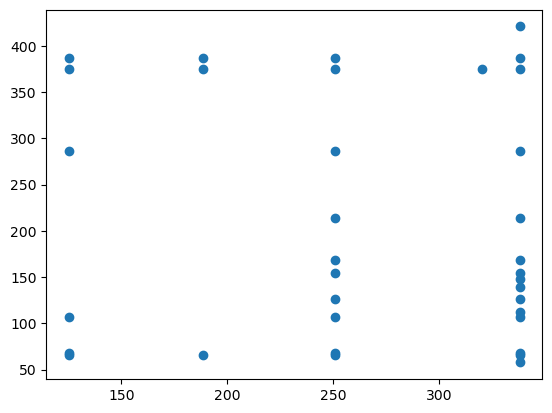

In [33]:
plt.scatter(jet1_flat[0:35] , jet2_flat[0:35]);
#plt.scatter(jet1_flat[35:70] , jet2_flat[35:70]);
#plt.scatter(jet1_flat[70:105] , jet2_flat[70:105]);
#plt.xlim(0,400);
#plt.ylim(0,1000);

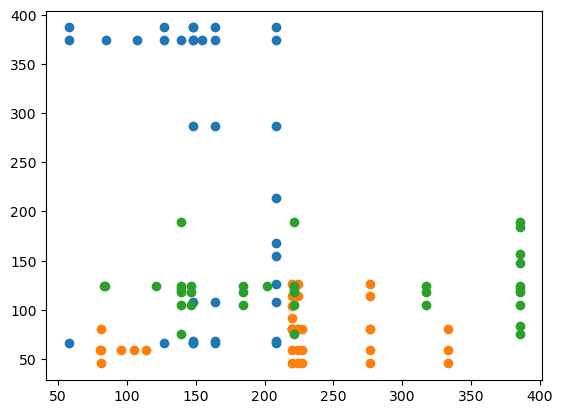

In [34]:
plt.scatter(jet3_flat[0:35] , jet4_flat[0:35]);
plt.scatter(jet3_flat[35:70] , jet4_flat[35:70]);
plt.scatter(jet3_flat[70:105] , jet4_flat[70:105]);

In [19]:
test_data = jets_ncut[0:1]
disjoint_combo1=[]
disjoint_combo2=[]
start_time1=time.time()
# Making disjointed 8C4 combinations
start_time2 = time.time()
quadrajet = ak.combinations(test_data, 4, fields=["j1", "j2", "j3","j4"])
for insanity in quadrajet: 
    disjoint_combo1.append(insanity[0:35])
    disjoint_combo2.append(insanity[35:70][::-1])
print(f"Pairing the 8C4 disjointed combinations: {time.time() - start_time2}")

# Calculating Dijet Masses from the First Quadjet 
start_time3 = time.time()
jet1=[]
jet2=[]
jet3=[]
jet4=[]
for jet_combo1,jet_combo2 in zip(disjoint_combo1,disjoint_combo2): 
    dijet1 = jet_combo1.j1 + jet_combo1.j2
    dijet2 = jet_combo1.j3 + jet_combo1.j4
    dijet3 = jet_combo2.j1 + jet_combo2.j2
    dijet4 = jet_combo2.j3 + jet_combo2.j4
    jet1.append(dijet1.mass) 
    jet2.append(dijet2.mass)
    jet3.append(dijet3.mass) 
    jet4.append(dijet4.mass)
  
print(f"Pairing and Calculating Mass of the Quadjets: {time.time() - start_time3}")

start_time5 = time.time()
jet1_flat = ak.flatten(jet1)
jet2_flat = ak.flatten(jet2)
jet3_flat = ak.flatten(jet3)
jet4_flat = ak.flatten(jet4)

print(f"Flattening the Data: {time.time() - start_time5}")

print(f"The whole code block: {time.time() - start_time1}")

Pairing the 8C4 disjointed combinations: 0.0017061233520507812
Pairing and Calculating Mass of the Quadjets: 0.025274038314819336
Flattening the Data: 0.0032181739807128906
The whole code block: 0.030477046966552734


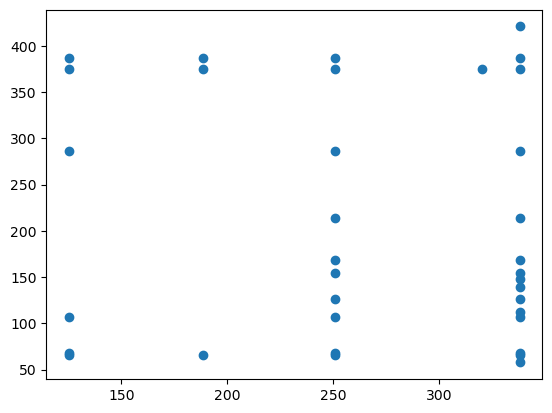

In [20]:
plt.scatter(jet1_flat, jet2_flat)

## Testing my Combinatorics Logic 

In [48]:
test_combo1=[]
test_combo2=[]
start_time_one=time.time()
test_data=jets_ncut[0:2]
dijet_combo=ak.combinations(test_data,2)
quadjet_combo=ak.combinations(dijet_combo,4,fields=["j1","j2","j3","j4"])
print(f"Combinations Done: {time.time()-start_time_one}")
for events in quadjet_combo: 
    for jet in events: 
        if len(set(ak.ravel([jet.j1.to_list(),jet.j2.to_list(),jet.j3.to_list(),jet.j4.to_list()]))) == 8: 
            test_combo1.append(jet)

Combinations Done: 0.0038809776306152344


In [50]:
ak.combinations(test_data, 2)[0]

<Array [({...}, {...}), ..., ({...}, ..., ...)] type='28 * (Momentum4D[pt: ...'>

In [52]:
test_combo1

[]

In [ ]:
ak_test = ak.Array([
[1,2,3,4,5,6,7,8],
[9,10,11,12,13,14,15,16]
])
combo1=[]
combo2=[]
ak_comb = ak.combinations(ak_test, 2)
ak_combII = ak.combinations(ak_comb,4,fields=["j1", "j2", "j3", "j4"])
for unique in ak_combII: 
    for stuff in unique: 
        if len(set(ak.ravel([stuff.j1.to_list(),stuff.j2.to_list(),stuff.j3.to_list(),stuff.j4.to_list()]))) == 8: 
            combo1.append(stuff)

In [ ]:
len(unique.j1[0].to_list())

In [ ]:
ak.ravel([stuff.j1.to_list(),stuff.j2.to_list(),stuff.j3.to_list(),stuff.j4.to_list()])

In [ ]:
combo1[104]

In [ ]:
ac[0][13:18]

In [ ]:
ac[0][18:22]

In [ ]:
ac[0][22:25]

In [ ]:
ac[0][25:27]

In [ ]:
ac[0][27]

In [ ]:
fields = jets.fields
print(fields)

for i in range(0,100):
    output = ""
    for jet in jets[i]:
        for f in fields:
            output += f'{f:6s}: {jet[f]:8.4f}  '
        output += '\n'
    print(output)